<a href="https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/treehot_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A hot tree tells better story than one-hot
> When doing classification with any model, one-hot or simple multiclass multi-hot encoding usually mark your target well, except in cases like tree structure category.

> eg. From an image, if the quality isn't so nice, you can't tell it's which kind of bulldog it is, but you're sure this is a bull dog, and be damned it's definetly not a cat.

> This makes engineering on many problemsets more scientific. If you can't label it precisely, then label its ancestory category (less precisely, but correct nontheless)

In [28]:
import requests

## Oncotree dataset

In [29]:
import pandas as pd
import numpy as np
import json

Oncotree is a cancer naming schema, that follows a tree structure, like lung cancer has subtypes eg small-cell lung cancer etc, see their [amazingly interactive website](http://oncotree.mskcc.org/#/home) to experience what's the data structure look like.

So for many medical data, they mark patients' diagnosed cancer as an entry in oncotree, this allow doctors to label the disease as detail as possible and not damaging the accuracy

In [30]:
tree_str = requests.get("http://oncotree.mskcc.org/api/tumorTypes/tree?&version=oncotree_latest_stable").text
tree = json.loads(tree_str)


## Print out preview
If you print out this tree, a huge tree actually, imagine each leaf/ branch/ trunk could be the predicting label

In [31]:
def print_tree(node, level=0):
    if "name" in node:
        print("\t"*level+"- "+node["name"])
    if "children" in node:
        for c,child in node["children"].items():
            print_tree(child, level=level+1)

print_tree(tree['TISSUE'])

- Tissue
	- Ovary/Fallopian Tube
		- Ovarian Cancer, Other
			- Ovarian Choriocarcinoma, NOS
			- High-Grade Neuroendocrine Carcinoma of the Ovary
			- High-Grade Serous Fallopian Tube Cancer
		- Ovarian Epithelial Tumor
			- Endometrioid Borderlin Ovarian Tumor
			- Serous Ovarian Cancer
				- High-Grade Serous Ovarian Cancer
				- Low-Grade Serous Ovarian Cancer
			- Brenner Tumor
				- Brenner Tumor, Benign
				- Brenner Tumor, Borderline
				- Brenner Tumor, Malignant
			- Clear Cell Borderline Ovarian Tumor
			- Ovarian Seromucinous Carcinoma
			- Ovarian Seromucinous Adenoma
			- Endometrioid Ovarian Cancer
			- Serous Borderline Ovarian Tumor
			- Mucinous Ovarian Cancer
			- Serous Borderline Ovarian Tumor, Micropapillary
			- Mixed Ovarian Carcinoma
			- Mucinous Borderline Ovarian Tumor
			- Clear Cell Ovarian Cancer
			- Small Cell Carcinoma of the Ovary
			- Ovarian Seromucinous Borderline Tumor
			- Ovarian Carcinosarcoma/Malignant Mixed Mesodermal Tumor
		- Ovarian Germ C

## Flatten Structure

Let's try  to flatten the tree structure in to a long dataframe, in data way it's much easier to process

In [46]:
%%time
rows = []

def squeeze_tree(node, level=0):
    row = dict((c, node.get(c)) for c in ["code","name","parent"])
    row.update({
        "level":level,
        })
    rows.append(row)
    if "children" in node:
        for c,child in node["children"].items():
            squeeze_tree(child, level=level+1)

squeeze_tree(tree['TISSUE'])

paper = pd.DataFrame(rows)

CPU times: user 5.87 ms, sys: 0 ns, total: 5.87 ms
Wall time: 10.4 ms


In [47]:
paper

,code,name,parent,level
0,TISSUE,Tissue,None,0
1,OVARY,Ovary/Fallopian Tube,TISSUE,1
2,OOVC,"Ovarian Cancer, Other",OVARY,2
3,OCNOS,"Ovarian Choriocarcinoma, NOS",OOVC,3
4,HGONEC,High-Grade Neuroendocrine Carcinoma of the Ovary,OOVC,3
...,...,...,...,...
864,SWDNET,Well-Differentiated Neuroendocrine Tumors of t...,GINETES,3
865,HGNES,High-Grade Neuroendocrine Carcinoma of the Sto...,GINETES,3
866,HGNEE,High-Grade Neuroendocrine Carcinoma of the Eso...,GINETES,3
867,ESCC,Esophageal Squamous Cell Carcinoma,STOMACH,2


### Parent Map

Parent map extracts the relation of (child-parent) pairs into python dictionary

In [116]:
parent_map = dict(paper[["code","parent"]].values)
parent_map

{'AA': 'SOFT_TISSUE',
 'AASTR': 'DIFG',
 'ABC': 'DLBCLNOS',
 'ABL': 'AMLNOS',
 'ACA': 'ADRENAL_GLAND',
 'ACBC': 'BRCA',
 'ACC': 'ADRENAL_GLAND',
 'ACCC': 'SACA',
 'ACLG': 'LGT',
 'ACML': 'MDS/MPN',
 'ACN': 'CUP',
 'ACPG': 'SELT',
 'ACPP': 'CPT',
 'ACRM': 'MEL',
 'ACYC': 'SACA',
 'ADMA': 'BONE',
 'ADNOS': 'CUP',
 'ADPA': 'SKIN',
 'ADRENAL_GLAND': 'TISSUE',
 'AECA': 'SKIN',
 'AFH': 'SOFT_TISSUE',
 'AFX': 'SKIN',
 'AGA': 'BOWEL',
 'AGNG': 'ENCG',
 'AHCD': 'MBN',
 'AIS': 'OTHER',
 'AITL': 'MTNN',
 'ALAL': 'MNM',
 'ALCL': 'MTNN',
 'ALCLALKN': 'ALCL',
 'ALCLALKP': 'ALCL',
 'ALKLBCL': 'MBN',
 'ALT': 'SOFT_TISSUE',
 'ALUCA': 'LNET',
 'AM': 'AMLNOS',
 'AMBL': 'EMBT',
 'AMKL': 'AMLNOS',
 'AML': 'MNM',
 'AMLBCRABL1': 'AMLRGA',
 'AMLCBFBMYH11': 'AMLRGA',
 'AMLCEBPA': 'AMLRGA',
 'AMLDEKNUP214': 'AMLRGA',
 'AMLGATA2MECOM': 'AMLRGA',
 'AMLMD': 'AMLNOS',
 'AMLMLLT3KMT2A': 'AMLRGA',
 'AMLMRC': 'AML',
 'AMLNOS': 'AML',
 'AMLNPM1': 'AMLRGA',
 'AMLRARA': 'AMLRGA',
 'AMLRBM15MKL1': 'AMLRGA',
 'AMLRGA': 'AM

In [35]:
!pip install -q forgebox

     |████████████████████████████████| 81kB 2.8MB/s 


In [36]:
from forgebox.category import Category

In [72]:
cate = Category(paper.code)

In [73]:
len(cate),cate.c2i[["HGNES","BRCA"]]

(869, array([865, 264]))

### Ancestor Map

Ancestor maps (child- [parent, parent's parent, parent's parent's parent, ...]) pair into a dictionary

In [62]:
def cache(f):
    data = dict()
    def wrapper(name, parent_map):
        if name in data:
            return data[name]
        rt = f(name, parent_map)
        data[name]=rt
        return rt
    return wrapper

@cache
def find_ancestor_map(name, parent_map):
    if name not in parent_map:
        return []
    else:
        return [name,]+find_ancestor_map(parent_map[name], parent_map)


In [63]:
ancestor_map = dict((name, find_ancestor_map(name, parent_map)) for name in parent_map.keys()) 

In [109]:
for k,v in ancestor_map.items():
    print(f"{k}:{v}")

TISSUE:['TISSUE']
OVARY:['OVARY', 'TISSUE']
OOVC:['OOVC', 'OVARY', 'TISSUE']
OCNOS:['OCNOS', 'OOVC', 'OVARY', 'TISSUE']
HGONEC:['HGONEC', 'OOVC', 'OVARY', 'TISSUE']
HGSFT:['HGSFT', 'OOVC', 'OVARY', 'TISSUE']
OVT:['OVT', 'OVARY', 'TISSUE']
EBOV:['EBOV', 'OVT', 'OVARY', 'TISSUE']
SOC:['SOC', 'OVT', 'OVARY', 'TISSUE']
HGSOC:['HGSOC', 'SOC', 'OVT', 'OVARY', 'TISSUE']
LGSOC:['LGSOC', 'SOC', 'OVT', 'OVARY', 'TISSUE']
BTOV:['BTOV', 'OVT', 'OVARY', 'TISSUE']
BTBEOV:['BTBEOV', 'BTOV', 'OVT', 'OVARY', 'TISSUE']
BTBOV:['BTBOV', 'BTOV', 'OVT', 'OVARY', 'TISSUE']
BTMOV:['BTMOV', 'BTOV', 'OVT', 'OVARY', 'TISSUE']
CCBOV:['CCBOV', 'OVT', 'OVARY', 'TISSUE']
OSMCA:['OSMCA', 'OVT', 'OVARY', 'TISSUE']
OSMAD:['OSMAD', 'OVT', 'OVARY', 'TISSUE']
EOV:['EOV', 'OVT', 'OVARY', 'TISSUE']
SBOV:['SBOV', 'OVT', 'OVARY', 'TISSUE']
MOV:['MOV', 'OVT', 'OVARY', 'TISSUE']
SBMOV:['SBMOV', 'OVT', 'OVARY', 'TISSUE']
MXOV:['MXOV', 'OVT', 'OVARY', 'TISSUE']
MBOV:['MBOV', 'OVT', 'OVARY', 'TISSUE']
CCOV:['CCOV', 'OVT', 'OVARY',

## Tree hot encoding
Translate a category into a nhot encoding, while any child node is hot, its all traceable ancestor node is hot

In [97]:
def tree_hot(cate, name, ancestor_map):
    target = np.zeros(len(cate), dtype=int)
    target[cate.c2i[ancestor_map[name]]]=1
    return target

def get_depth_map(cate, ancestor_map):
    cate.depth_map = dict(
        (k, len(v)) for k,v in ancestor_map.items())
    return cate.depth_map

def get_depth_map_array(cate, ancestor_map):
    cate.depth_map_array = np.vectorize(cate.get_depth_map(ancestor_map).get)(cate.i2c)
    return cate.depth_map_array

Category.tree_hot = tree_hot
Category.get_depth_map = get_depth_map
Category.get_depth_map_array = get_depth_map_array

Then the following target honestly represent the true distribution of a tree structure

In [110]:
y = cate.tree_hot("CMLBCRABL1", ancestor_map)
y

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [107]:
depth_map_array = cate.get_depth_map_array(ancestor_map)
depth_map_array

array([1, 2, 3, 4, 4, 4, 3, 4, 4, 5, 5, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 2, 3,
       4, 5, 5, 5, 5, 5, 5, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 5, 6,
       6, 7, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 7, 6,
       7, 7, 6, 6, 7, 7, 7, 6, 7, 7, 5, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 5,
       6, 6, 6, 6, 4, 5, 5, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 2, 3,
       3, 3, 4, 4, 3, 3, 3, 3, 2, 3, 4, 4, 4, 2, 3, 3, 3, 3, 4, 3, 3, 3,
       4, 4, 4, 4, 4, 3, 2, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 2, 3, 3, 4, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 5, 5, 5, 4, 3,
       3, 4, 5, 5, 5, 4, 5, 5, 5, 2, 3, 3, 3, 4, 3,

In [114]:
cate.i2c[y==1], depth_map_array[y==1]

(array(['TISSUE', 'MYELOID', 'MNM', 'MPN', 'CML', 'CMLBCRABL1'],
       dtype='<U16'), array([1, 2, 3, 4, 5, 6]))

Visualize level for first 100 categories

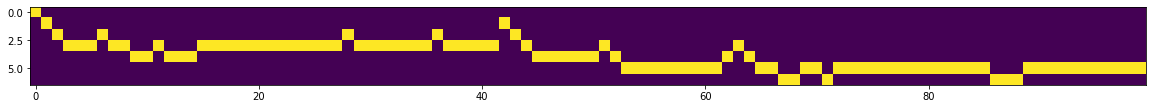

In [130]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(np.stack(list(depth_map_array==i for i in range(1,depth_map_array.max()+1)))[:,:100])

Visualize dependency of first 100 categories, category on y-axis, depends on categories on x-axis

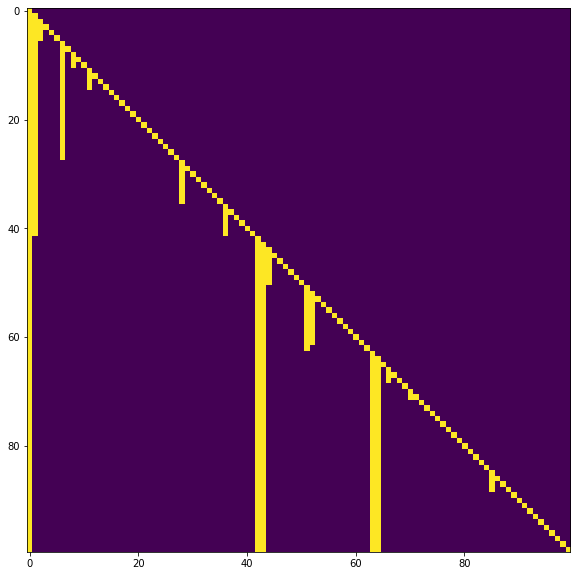

In [131]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(np.stack(list(cate.tree_hot(cate.i2c[i], ancestor_map) for i in range(0,100)))[:,:100])

In [115]:
for i in range(1,depth_map_array.max()+1):
    level_sum = y[depth_map_array==i].sum()
    print(f"level:{i}\tlevel sum:{level_sum}")

level:1	level sum:1
level:2	level sum:1
level:3	level sum:1
level:4	level sum:1
level:5	level sum:1
level:6	level sum:1
level:7	level sum:0


## Pack things up
All there will be in [forgebox.category, see doc here](https://raynardj.github.io/forgebox/category/)